# Rendu ISEG - Thibault VIENNOT

Ce notebook contient le code et les explications de compréhension de Thibault VIENNOT. Il réponds étape par étape à la problématique posé par le challenge ISEG 2017.
Les morceaux de code sont commentés au mieux pour facilité la lecture.

In [1]:
# La liste des imports nécessaires au bon fonctionnement du projet

import numpy as np
import matplotlib as mat
import tensorflow as tf
import nibabel as nib

from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt

## Dataset & fichiers auxiliaires

Toutes les images composantes le dataset de training sont positionné dans le dossier "Datasets" à la racine du dossier de rendu.
Similairement les fichiers contenants les poids entainés des reseaux neronaux sont dans le dossier "pretrained_weights".

## STEP 1 : Chargement et affichage des données

In [2]:
# Les fichiers sont chargés en utilisant la librairie Nibabel puis stockés dans les listes suivantes:

base_T1 = []
base_T2 = []
base_VT = []


# Comme le nom des fichiers suis la convention suivante "numéropatient-type" 
# nous pouvons utiliser une simple boucle pour tous les charger 
x = 0
while (x < 10):
  base_T1.append(nib.load("Datasets/iSeg-2017-Training/subject-"+str(x + 1)+"-T1.img"))
  base_T2.append(nib.load("Datasets/iSeg-2017-Training/subject-"+str(x + 1)+"-T2.img"))
  base_VT.append(nib.load("Datasets/iSeg-2017-Training/subject-"+str(x + 1)+"-label.img"))
  x += 1

In [3]:
# Une fois les fichiers chargés nous pouvons extraires les données dedans avec la fonction suivante
def extract_data(source, target):
  for x in source :
    data = x.get_fdata()
    squeezed_data = np.squeeze(data)
    image = np.array(squeezed_data)
    target.append(image)

In [4]:
# Nous extrayons tous les données dans les listes suivantes
data_T1 = []
data_T2 = []
data_VT = []

extract_data(base_T1, data_T1)
extract_data(base_T2, data_T2)
extract_data(base_VT, data_VT)

In [6]:
# La fonction suivante nous permet d'afficher le scan d'un patient sous 3 angles différents
def image_to_plot(to_plot, title):
  plot = plt.figure(figsize=(14,4))

  plot.suptitle(title, fontsize=16)
  plot.add_subplot(1, 3, 1)

  # pour le premier angle du patient nous fixons la coordonné X à 72
  plt.imshow(to_plot[72,:,:]) 
  plt.axis('off')
  plt.title("X = 72")

  plot.add_subplot(1, 3, 2)

  # pour le deuxieme angle du patient nous fixons la coordonné Y à 96
  plt.imshow(to_plot[:,96,:])
  plt.axis('off')
  plt.title("Y = 96")

  plot.add_subplot(1, 3, 3)
  
  # pour le dernier angle du patient nous fixons la coordonné Z à 128
  plt.imshow(to_plot[:,:,128])
  plt.axis('off')
  plt.title("Z = 128")


  plot.show()

In [8]:
# Cette courte fonction nous permet d'afficher les 2 scans et vérité terrain de chaque patient dans les listes
def display_data(T1, T2, VT):
  nb = 1
  for (image1, image2, image3) in zip(T1, T2, VT):
    image_to_plot(image1, f" - - - - Patient {nb} T1 - - - -")
    image_to_plot(image2, f" - - - - Patient {nb} T2 - - - -")
    image_to_plot(image3, f" - - - - Patient {nb} VT - - - -")
    nb+=1

### l'Affichage des coupes médianes des 10 patients 

#### Classification des valeurs dans les images VT
- 0 -> Fond
- 10 -> Crâne
- 150 -> GM (grey matter / matière grise)
- 250 -> WM (white matter / matière blanche)

C:\Users\thiba\AppData\Local\Temp\ipykernel_22140\1453063934.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  plot.show()
C:\Users\thiba\AppData\Local\Temp\ipykernel_22140\1453063934.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plot = plt.figure(figsize=(14,4))


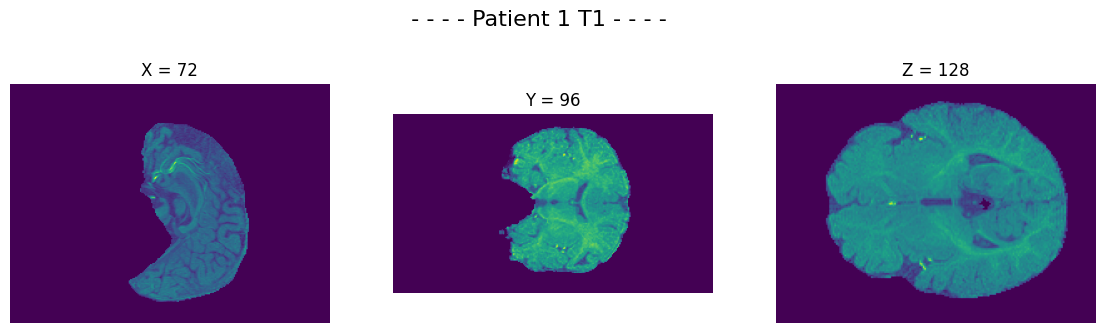

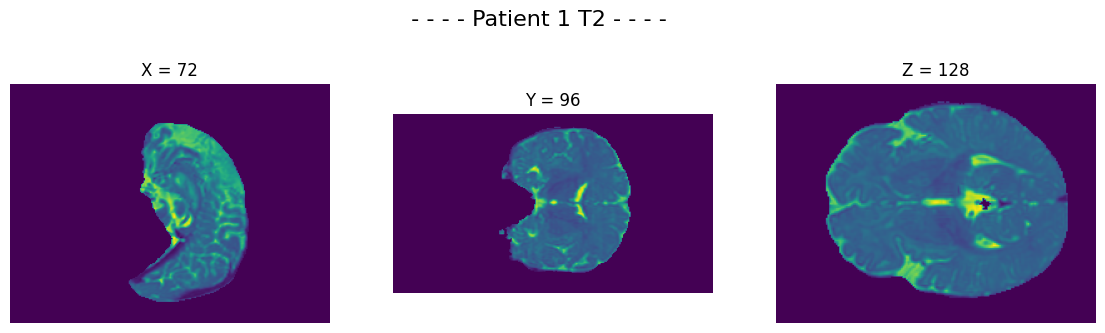

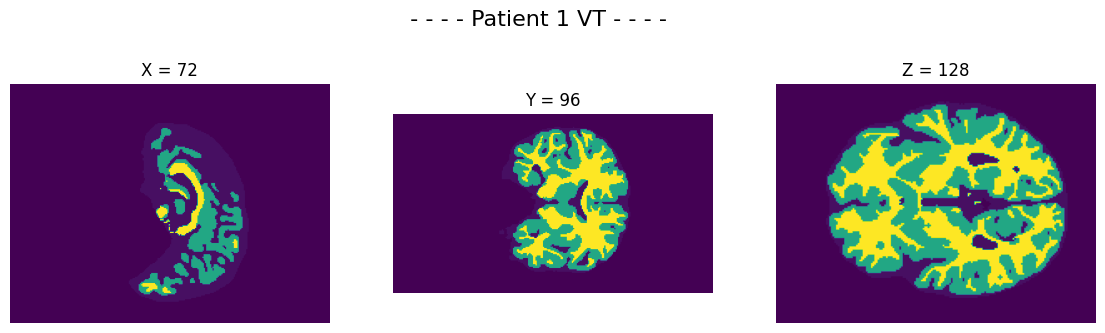

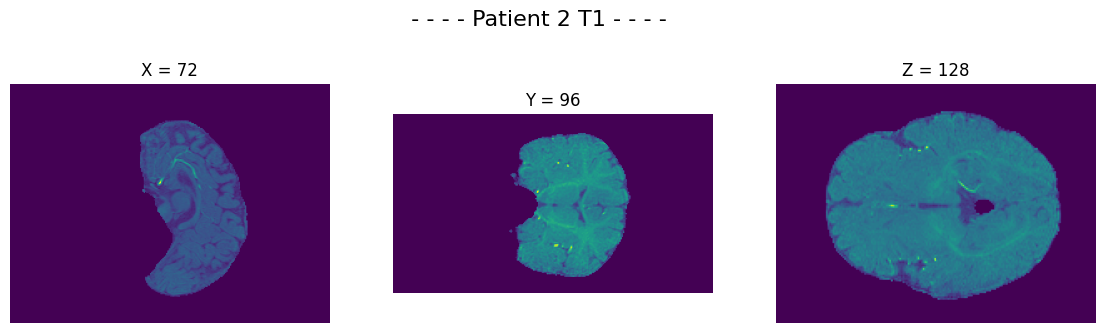

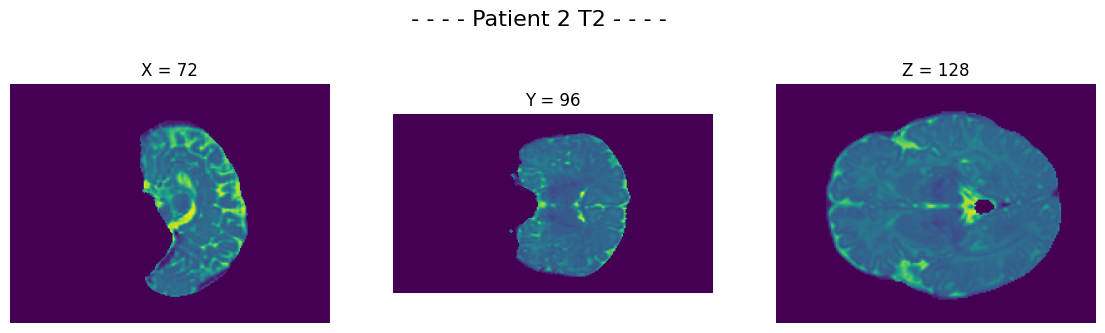

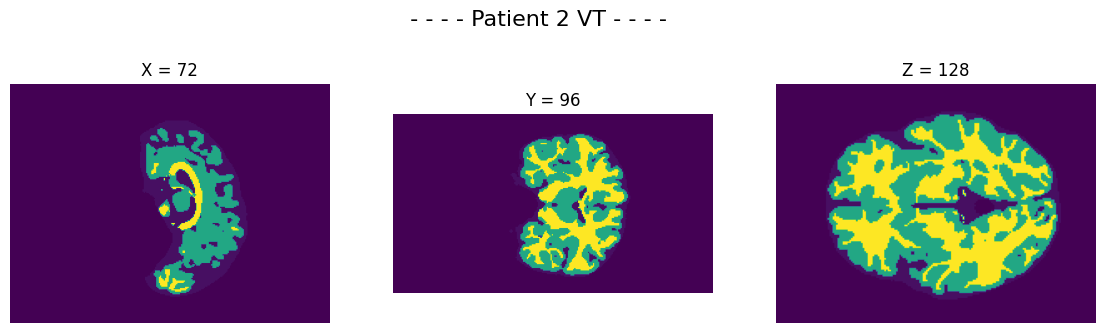

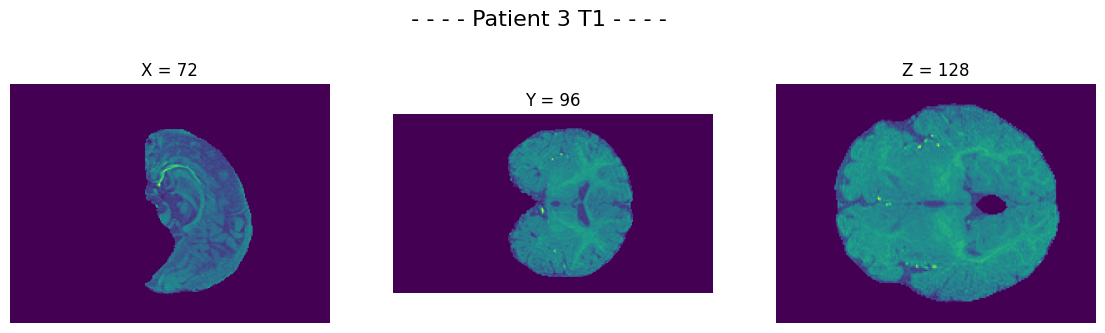

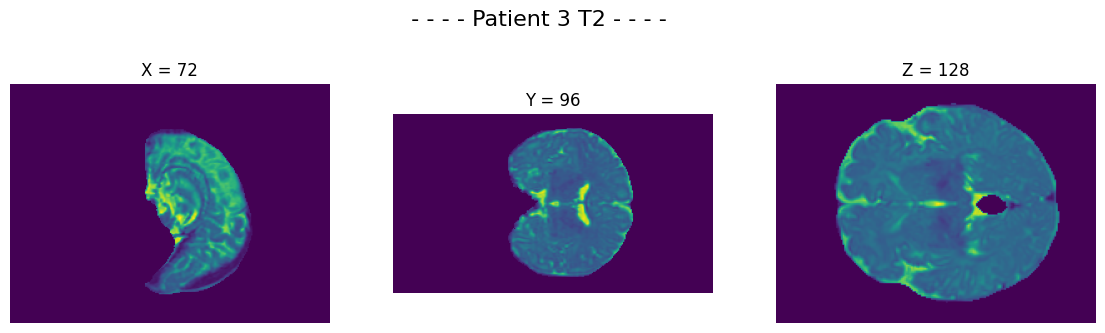

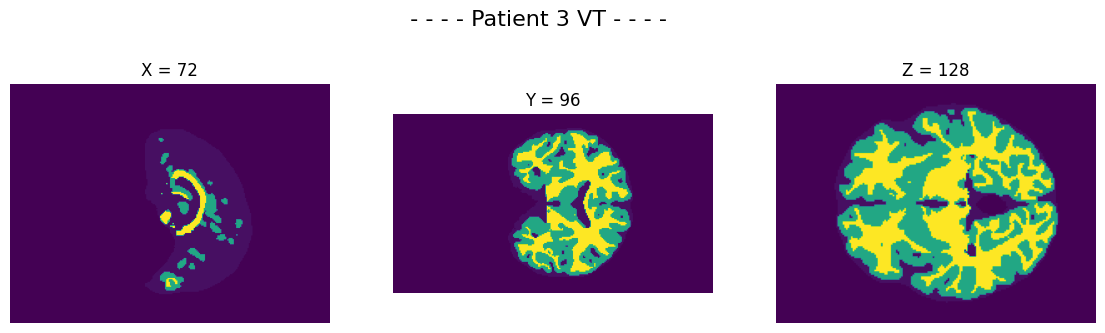

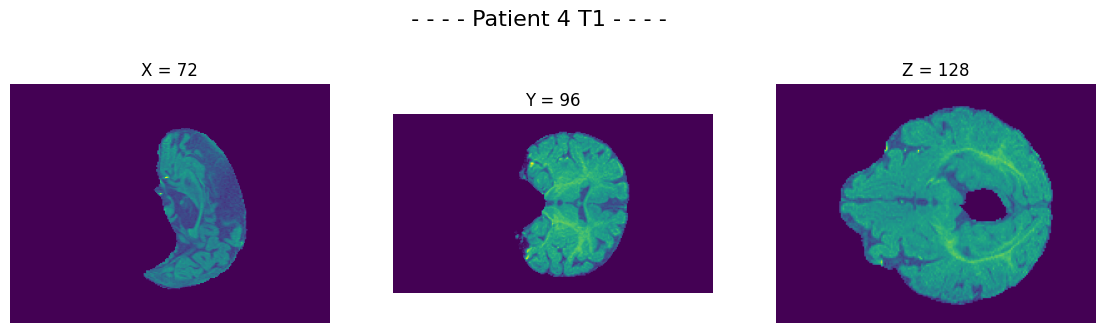

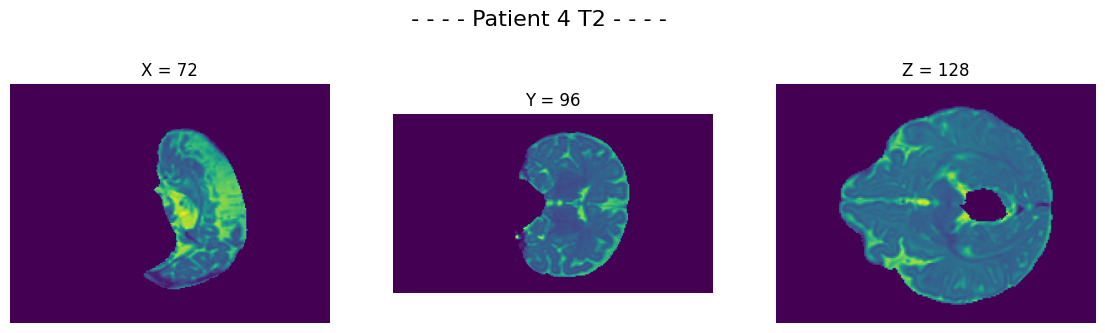

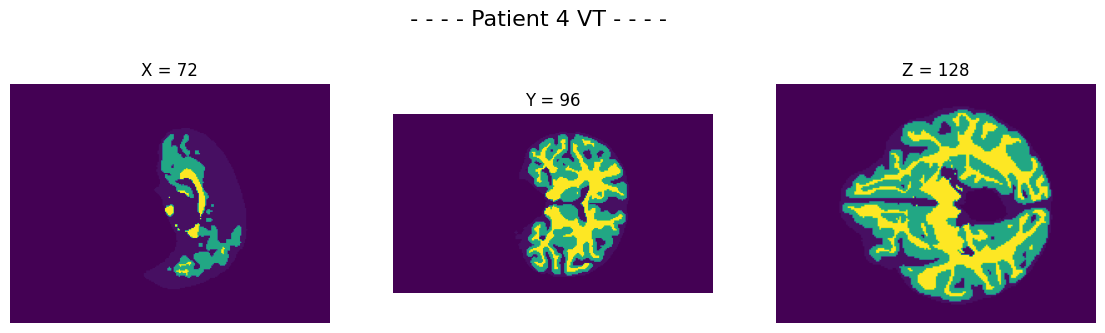

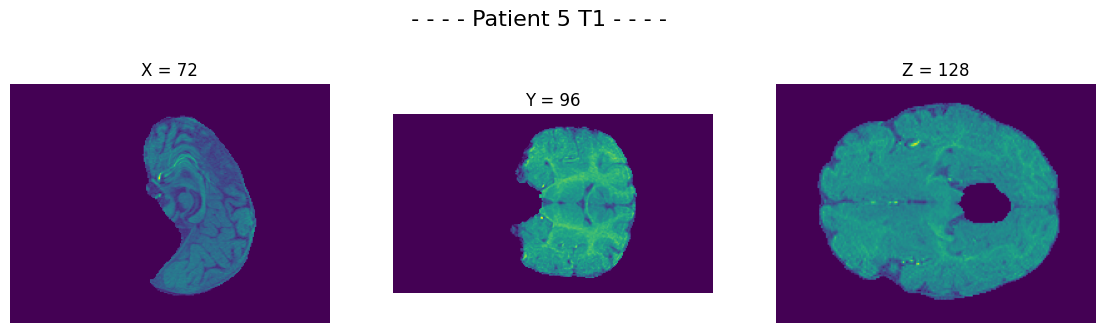

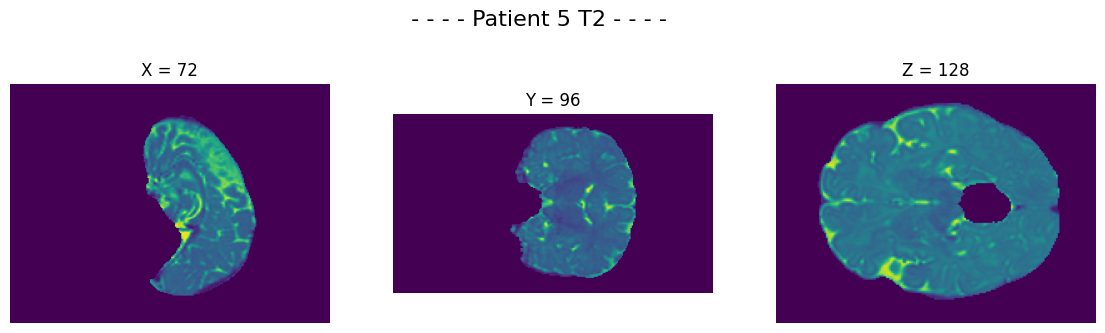

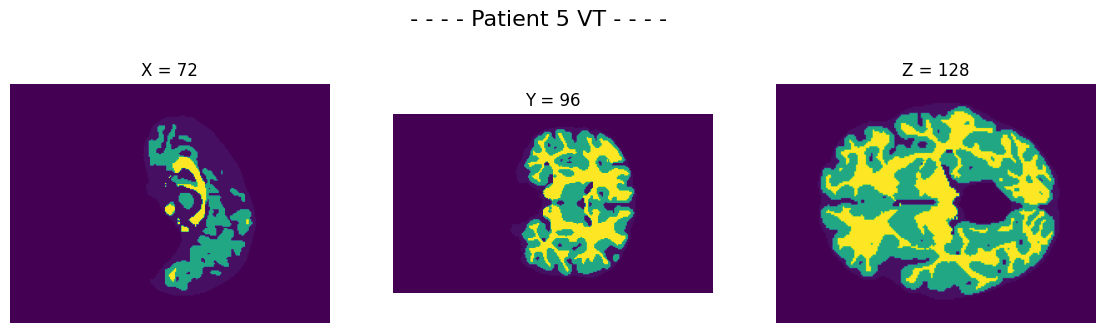

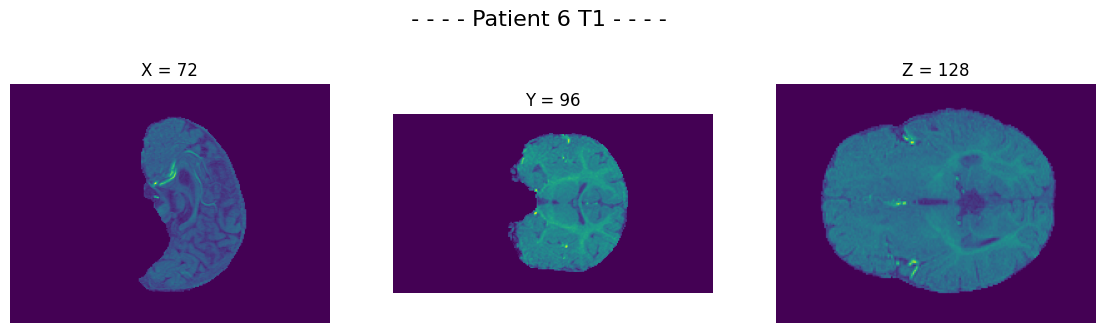

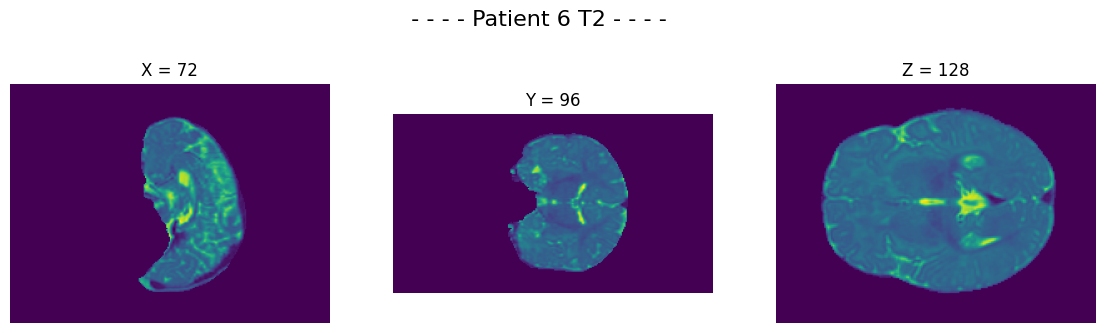

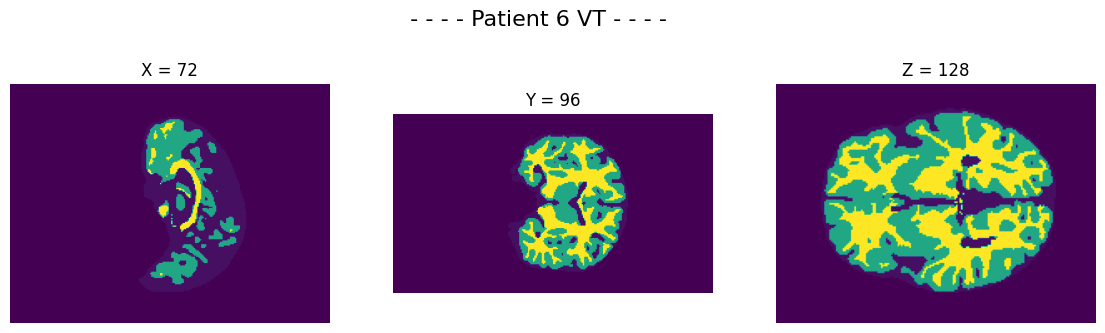

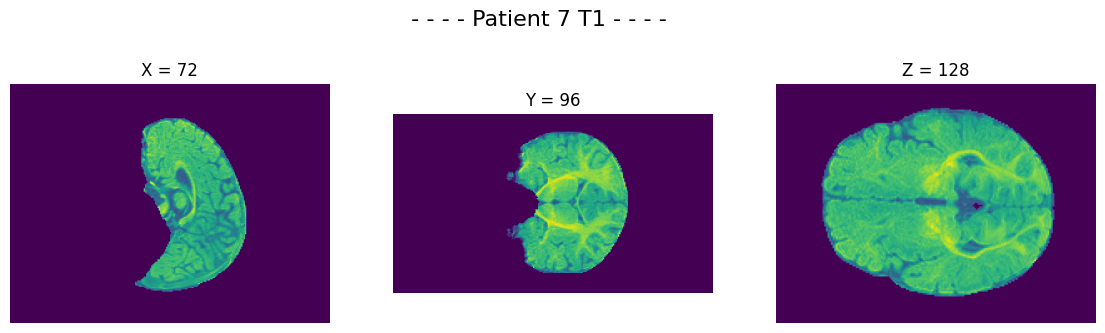

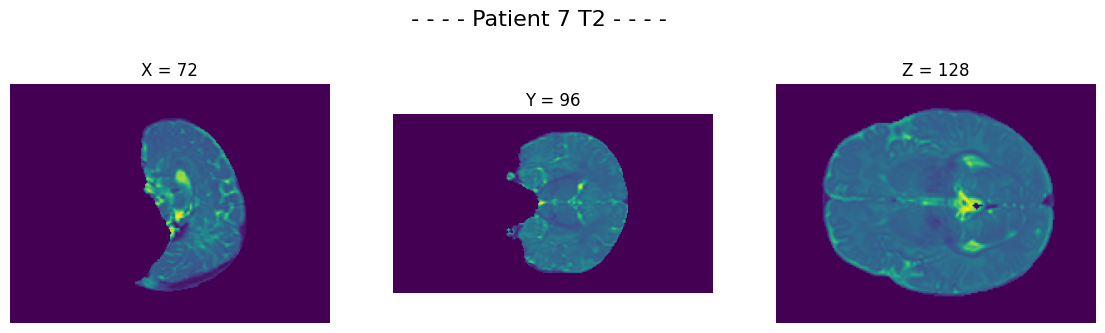

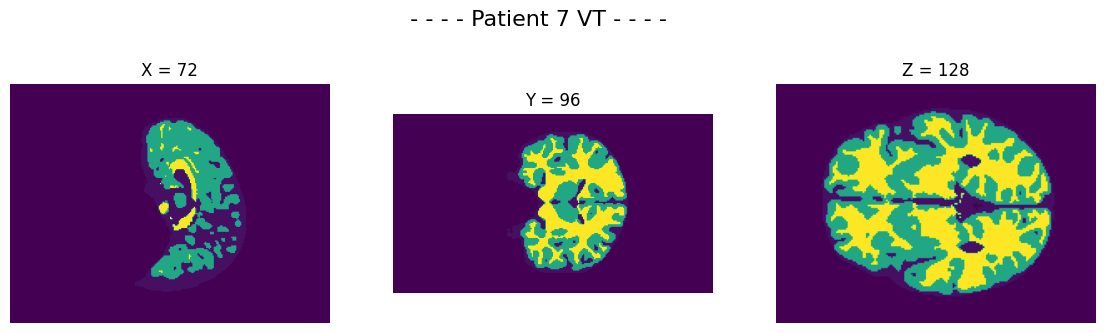

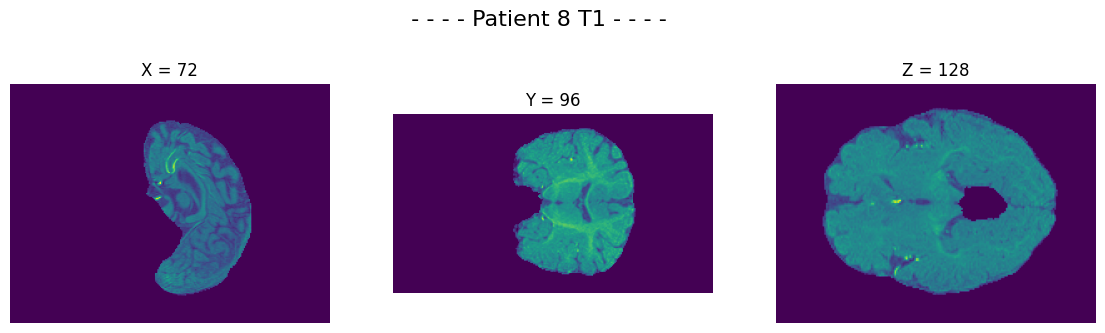

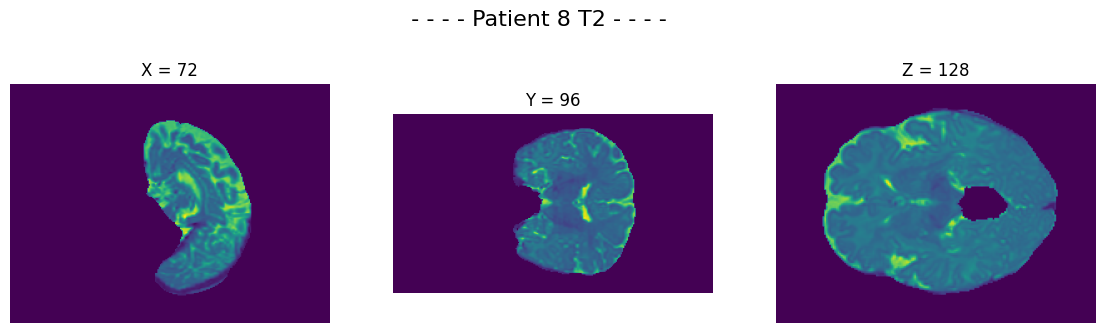

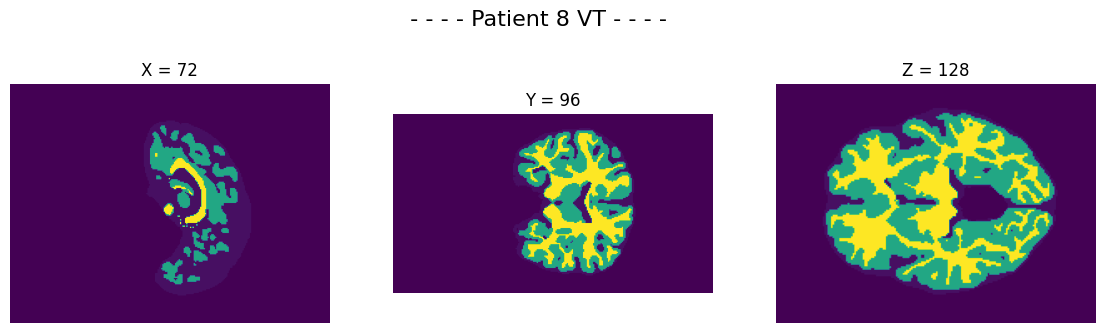

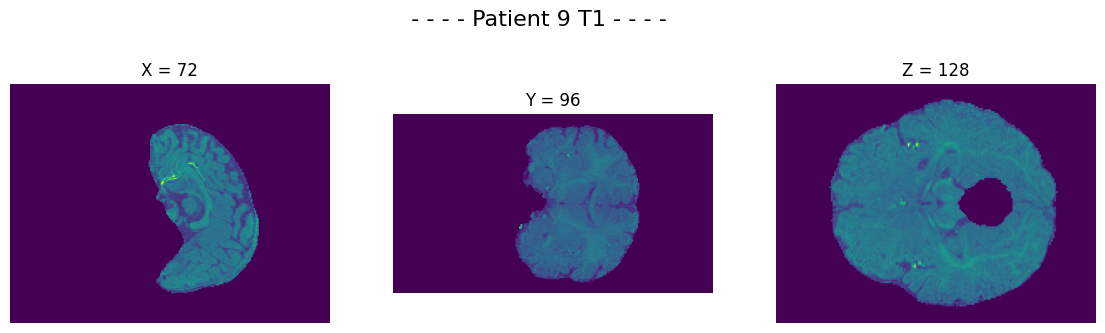

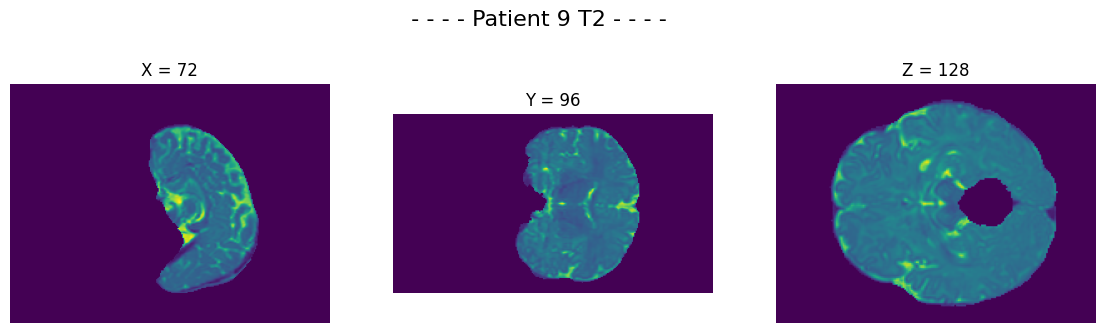

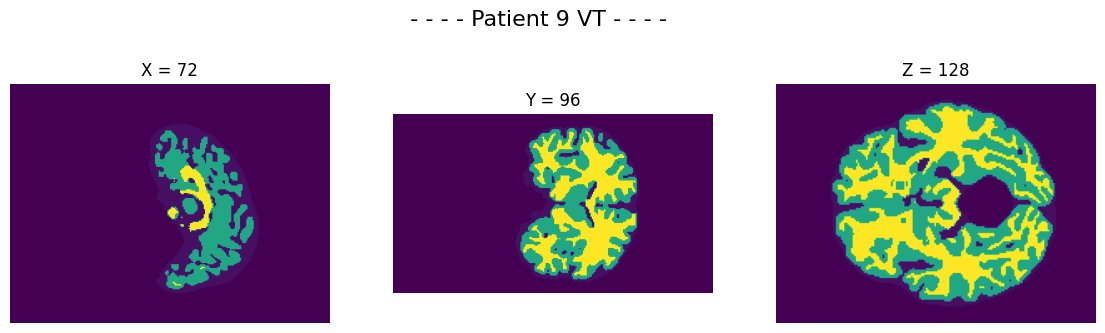

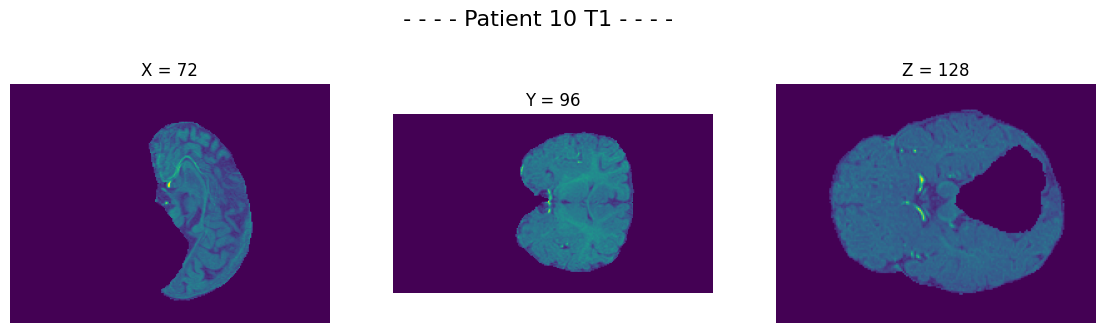

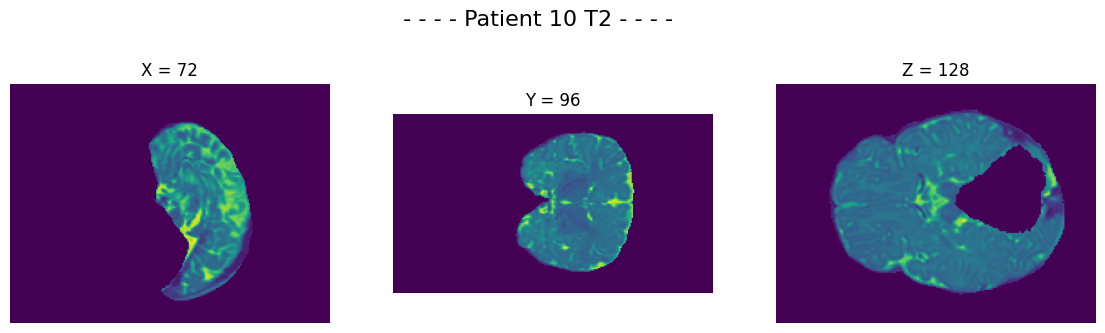

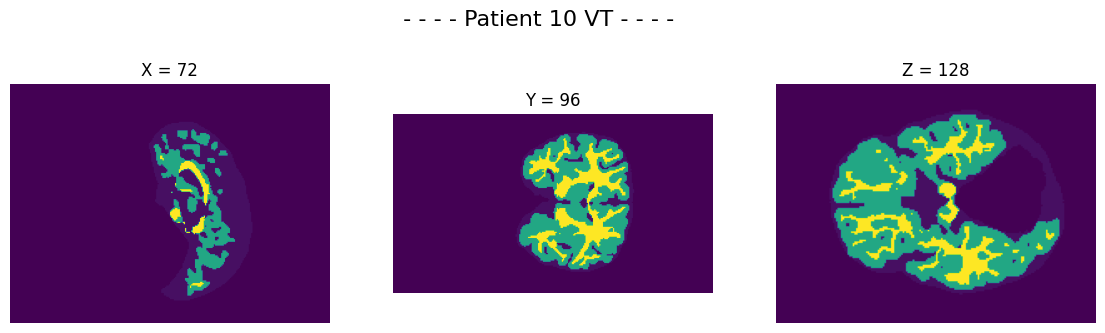

In [9]:
display_data(data_T1, data_T2, data_VT)


### Question - Commencer a savoir repérer les zones en regardant le match entre la VT et les T1 et T2 (l’expliquer dans le notebook/rapport).

Nous pouvons voir très rapidement que les zones en noir sont le background.
Nous voyons aussi que les zones sombres en T1 qui deviennent très claire en T2 représentent le crâne du patient.
Les zones qui sont moyennement clair en T1 et qui le sont aussi en T2 seront considéré comme étant de la matière grise.
Finalement les zones qui sont particulièremetn claires dans les images T1 et sombre dans les images T2 seront classifiées en tant que matière blanche.

## STEP 2 - Normalisation des données

In [69]:
# cette courte fonction nous permet de normaliser une image
def gaussian(img):
  img2 = img[img >= 0]
  mean = np.mean(img2)
  std = np.std(img2)
  return (img - mean) / (5 *std)

# normalization Gaussienne des images T1 et T2
gauss_T1 = np.copy(data_T1)
gauss_T2 = np.copy(data_T2)


for i in range(10):
  gauss_T1[i] = gaussian(gauss_T1[i])

for i in range(10):
  gauss_T2[i] = gaussian(gauss_T2[i])

### Question - il ne sert a rien de normaliser la VT (et même, cela n’a pas de sens!), expliquer pourquoi.

Les images VT correspondent à la vérité terrain: ce sont de annotations qu'ont fait des medecins sure ces images.
Il ne sert à rien de les normaliser car il ne peut y avoir que 4 valeures dans les images VT : 0, 10, 150 ou 250. Si nous normalisons ces images nous aurons exactement la même image mais avec ses valeurs recentrées.

## Step 3 : Formatage des données en mode 2D

In [70]:
# Séparation des données en cohortes d'entrainement , validation et test

train_T1 = [x for x in gauss_T1[0:6]]
train_T2 = [x for x in gauss_T2[0:6]]
train_VT = [x for x in data_VT[0:6]]

####################

val_T1 = [x for x in gauss_T1[6:8]]
val_T2 = [x for x in gauss_T2[6:8]]
val_VT = [x for x in data_VT[6:8]]

######################

test_T1 = [x for x in gauss_T1[8:]]
test_T2 = [x for x in gauss_T2[8:]]
test_VT = [x for x in data_VT[8:]]

In [71]:
# nombre de coupes ayant "threshold" pixels non vides
def get_nb_coupes(training, threshold = 100):
  nb_coupes = 0
  for elt in training:
    for i in range(elt.shape[2]):
      nb_coupes += np.sum(np.where(elt[:,:, i] > 0, 1, 0)) > threshold
  return nb_coupes

In [72]:
# nombres total de coupes dans une liste
def get_nb_coupes_tot(target_list):
  nb_coupes = 0
  for elt in target_list:
    for i in range(elt.shape[2]):
      nb_coupes += 1
  return nb_coupes

In [73]:
# Ci suit l'acquisition du nombre de tranches valides pour la cohorte d'entraînement

nb_coupes_T1 = get_nb_coupes(train_T1) # 599
nb_coupes_T2 = get_nb_coupes(train_T2) # 599
nb_coupes_VT = get_nb_coupes(train_VT) # 599

In [74]:
# La fonction suivante nous permet d'extraire toutes les coupes interessantes des listes d'images T1, T2 et VT 
# puis de les mettres dans la structure X ou Y 
# Ces structurs seront passé eventuellement à notre réseau neuronal pour l'entrainer 
def extract_valid(T1, T2, VT, X, Y, threshold = 100):
  n = 0
  for (a, b, v) in zip(T1, T2, VT):
    for z in range(VT[0].shape[2]):
      if np.sum(np.where(v[:,:, z] > 0, 1, 0)) > threshold :
         X[n,:,:,0] = a[:,:, z]
         X[n,:,:,1] = b[:,:, z]
         Y[n,:,:] = np.where(v[:,:,z] > 0, 1, 0)
         n += 1

In [75]:
# Nous créons et remplissons les structures XTRAIN et YTRAIN
XTRAIN = np.zeros((nb_coupes_VT, train_VT[0].shape[0], train_VT[0].shape[1], 2))
YTRAIN = np.zeros((nb_coupes_VT, train_VT[0].shape[0], train_VT[0].shape[1]))

extract_valid(train_T1, train_T2, train_VT, XTRAIN, YTRAIN)

In [76]:
# Ci suit l'acquisition du nombre de tranches valides pour la cohorte de validation

nb_coupes_T1_valid = get_nb_coupes(val_T1) # 199
nb_coupes_T2_valid = get_nb_coupes(val_T2) # 199
nb_coupes_VT_valid = get_nb_coupes(val_VT) # 199

In [77]:
# Nous créons et remplissons les structures XVALID et YVALID

XVALID = np.zeros((512, train_VT[0].shape[0], train_VT[0].shape[1], 2))
YVALID = np.zeros((512, train_VT[0].shape[0], train_VT[0].shape[1]))

extract_valid(val_T1, val_T2, val_VT, XVALID, YVALID, 0)

## Annexe - fonction créatrice de UNETs

In [78]:
# Ce fichier défini une fonction qui crée des Unets. Nous l'utilserons pour créer nos trois models au long de ce notebook Jupyter
# Ce fichier à été téléchargé depuis https://github.com/zhixuhao/unet/blob/master/model.py

import numpy as np
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
nbf64= 8

def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128 / nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128 / nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256 / nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256 / nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512 / nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512 / nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024 / nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024 / nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512 / nbf64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512 / nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512 / nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256 / nbf64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256 / nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256 / nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128 / nbf64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128 / nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128 / nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(nbf64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(nbf64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)

    model.compile(optimizer = Adam(learning_rate = 1e-6), loss = 'binary_crossentropy', metrics = ['accuracy'])

    #model.summary()

    if(pretrained_weights):
        model.load_weights(pretrained_weights)

    return model

## Step 4 : un premier entraînement de réseau !

In [79]:
# En lancant ce bloc de code, nous créons un nouveau modèle à partir de zéro et nous commençons à l'entraîner.
# !! Cela va écraser les pois entrainé au préalable!!!

# first_model = None
# first_model = unet(input_size=(144, 192, 2))
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1E-6, restore_best_weights=True)
# first_model.fit(XTRAIN, YTRAIN, batch_size=2, epochs=50, verbose=1, validation_data=(XVALID, YVALID), shuffle=True, callbacks=[early_stopping])
# first_model.save("pretrained_weights/first_model.h5")

In [80]:
# Ici plutôt que d'entrainer un réseau à partir de rien à chaque lancerment de ce notebook 
# Nous en chargeons un depuis un fichier que nous aurons généré au préalble

first_model = None
first_model = unet(pretrained_weights="pretrained_weights/first_model.h5", input_size=(144, 192, 2))

## Step 5 : Finir la première étape de la cascade

In [81]:
# Cette fonction nous permet de faire une prédiction en utilisant notre premier model
def predict_first_model(T1, T2, model):
  # notre réseau prends en entrée une structure ayant la forme suivante : (1, 144, 192, 2)
  # nous devons donc créer cette steructure et la garnir de données
  X = np.zeros((1, T1[0].shape[0], T1[0].shape[1], 2))
  res = []

  for i in range(len(T1)):
    out = np.zeros((144, 192, 256))
    for z in range(T1[0].shape[2]):
      # nous mettons les donnes de T1 et T2 dans la structure que notre réseau peut accepter
      X[0,:,:,0] = T1[i][:,:,z]
      X[0,:,:,1] = T2[i][:,:,z]
      OUTPUT = model.predict(X, verbose=0)
      OUTPUT_FINALE = np.where(OUTPUT > 0.5, 1, 0)
      # une fois la prédiction pour une coupe faite nous la concaténons aux coupes précédentes pour réassembler une image 3D
      out[:,:,z] = np.squeeze(OUTPUT_FINALE)
    res.append(out)

  return res

In [82]:
test_pred = predict_first_model(test_T1, test_T2, first_model)

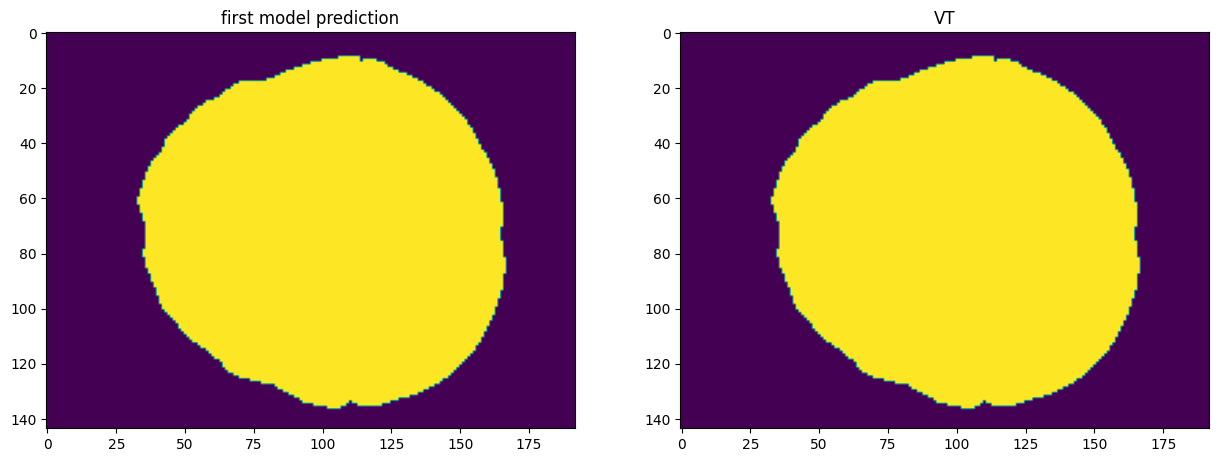

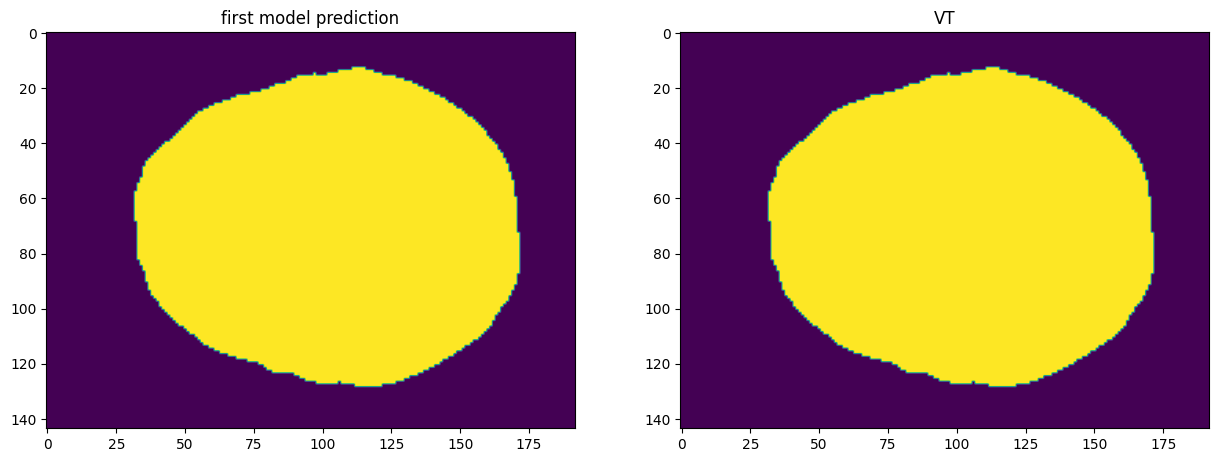

In [83]:
# Ces lignes nous permettent d'afficher la prédiction du premier modèle (à gauche) et de ce qui est annoté dans VT (à droite)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,15])
ax1.set_title("first model prediction")
ax1.imshow(test_pred[0][:,:,150])
ax2.set_title("VT")
ax2.imshow(np.where(test_VT[0][:,:,150] > 0, 1, 0))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,15])
ax1.set_title("first model prediction")
ax1.imshow(test_pred[1][:,:,150])
ax2.set_title("VT")
ax2.imshow(np.where(test_VT[1][:,:,150] > 0, 1, 0))

In [84]:
# La fonction suivante nous permet de trouver la valeure Dice de notre prédiction
def dice(X, Y):
  Xbin = (X > 0)
  Ybin = (Y > 0)
  Xsum = np.sum(Xbin)
  Ysum = np.sum(Ybin)
  XYand = np.sum(np.logical_and(Xbin, Ybin))
  if Ysum + Xsum > 0:
    dice = (2 * XYand) / (Ysum + Xsum)
    return dice
  return 0

In [85]:
# Ici nous avons un dice de 0.999998 sur notre image
print("The test dice factor is :  ", dice(test_pred[0], np.where(test_VT[0] > 0, 1, 0))) 

The test dice factor is :   0.9999982349878361


## Step 6 : Programmation de l’étage 2 de la cascade

Dans cette partie nous faisons essentiellement les mêmes manipulations que dans les étapes 3, 4 et 5 mais avec une couche de donnée en plus : la prédiction de notre premier model.

In [86]:
# Similairement à la fonction 'extract_valid' de la Step 2, cette fonction nous permet d'organiser nos données
# dans une strucutre qui peut être accepté par notre second réseau neuronal. 
# La différence avec la dernière fonction réside dans le fait que nous avons ajouté un nouveau canal dans la structure X.
# En théorie il s'agit des prédisction de notre model précedent cependant en réalité nous avons inséré des valeures de VT
# ajustées afin de minimiser l'accumulation d'erreures
def extract_valid_second_model(T1, T2, VT, X, Y):
  n = 0
  for (a, b, v) in zip(T1, T2, VT):
    vt_crane = np.where(v >= 10, 1, 0)
    vt_gm = np.where(v >= 150, 1, 0)
    for z in range(VT[0].shape[2]):
      X[n,:,:,0] = a[:,:, z]
      X[n,:,:,1] = b[:,:, z]
      X[n,:,:,2] = vt_crane[:,:,z]
      Y[n,:,:,0] = vt_gm[:,:, z]
      n += 1

In [87]:
# Nous créons et remplissons les structures XTRAIN et YTRAIN pour le second model

XTRAIN_second_model = np.zeros((1536, train_VT[0].shape[0], train_VT[0].shape[1], 3))
YTRAIN_second_model = np.zeros((1536, train_VT[0].shape[0], train_VT[0].shape[1], 1))

extract_valid_second_model(train_T1, train_T2, train_VT, XTRAIN_second_model, YTRAIN_second_model)

In [88]:
# Nous créons et remplissons les structures XVALID et YVALID pour le second model

XVALID_second_model = np.zeros((512, train_VT[0].shape[0], train_VT[0].shape[1], 3))
YVALID_second_model = np.zeros((512, train_VT[0].shape[0], train_VT[0].shape[1], 1))

extract_valid_second_model(val_T1, val_T2, val_VT, XVALID_second_model, YVALID_second_model)

In [89]:
# En lancant ce bloc de code, nous créons un nouveau modèle à partir de zéro et nous commençons à l'entraîner.
# !! Cela va écraser les pois entrainé au préalable!!!

# second_model = None
# second_model = unet(input_size=(144, 192, 3))
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1E-6, restore_best_weights=True)
# second_model.fit(XVALID_second_model, YVALID_second_model, batch_size=2, epochs=50, verbose=1, validation_data=(XVALID, YVALID), shuffle=True, callbacks=[early_stopping])
# second_model.save("pretrained_weights/second_model.h5")

In [90]:
# Comme le premier réseau: au lieu d'entrainer un réseau à partir de rien à chaque lancerment 
# Nous en chargeons un depuis un fichier que nous aurons généré au préalble
second_model = None
second_model =  unet(pretrained_weights="pretrained_weights/second_model.h5", input_size=(144, 192, 3))

In [91]:
# Comme à la Step 5 nous faisons une fonction qui nosu permet de faire une prédiction mais cette fois ci en utilisant notre 2e model
# Avec une couche en plus dans les données qui lui sont données
def predict_second_model(T1, T2, VT, nn):
  X = np.zeros((1, VT[0].shape[0], VT[0].shape[1], 3))
  res = []

  for (a, b, v) in zip(T1, T2, VT):
    out = np.zeros((144, 192, 256))
    crane = np.where(v >= 10, 1, 0)
    for z in range(a.shape[2]):
      X[0,:,:,0] = a[:,:,z]
      X[0,:,:,1] = b[:,:,z]
      X[0,:,:,2] = crane[:,:,z]
      OUTPUT = nn.predict(X, verbose =0)
      OUTPUT_FINALE = np.where(OUTPUT > 0.5, 1, 0)
      out[:,:,z] = np.squeeze(OUTPUT_FINALE)
    res.append(out)

  return res

In [92]:
val_pred_second_model = predict_second_model(test_T1, test_T2, test_VT, second_model)

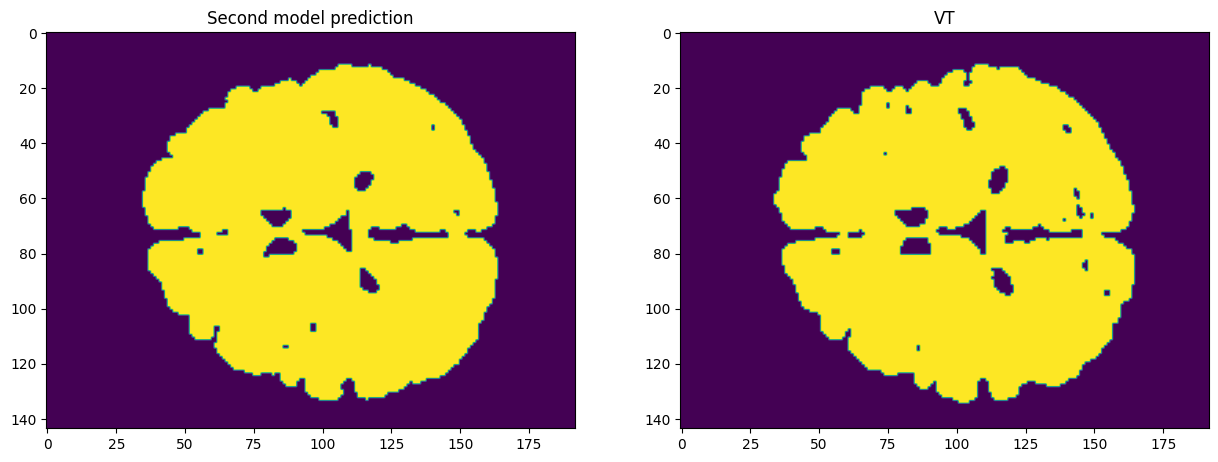

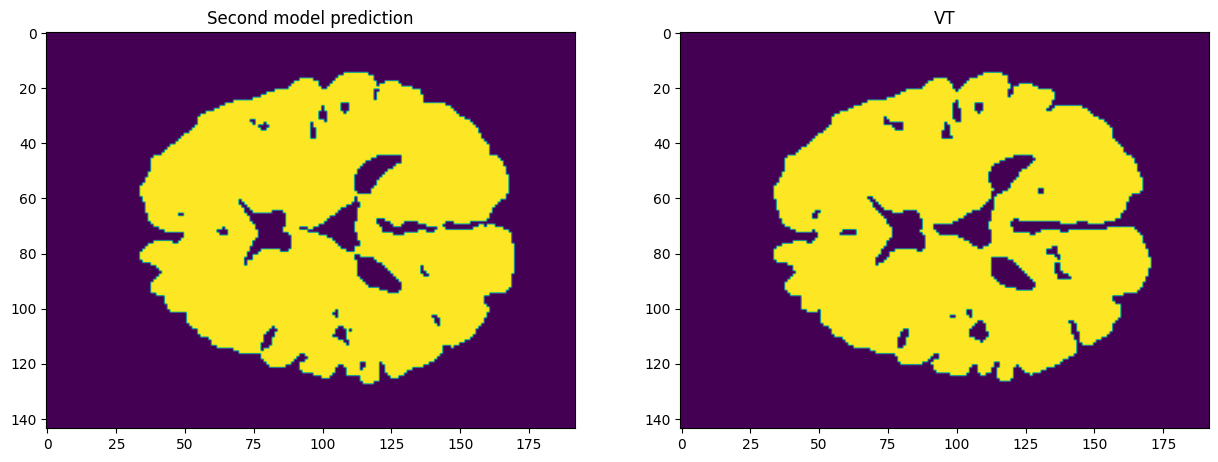

In [93]:
# Ces lignes nous permettent d'afficher la prédiction du deuxième modèle (à gauche) et de ce qui est annoté dans VT (à droite)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,15])
ax1.set_title("Second model prediction")
ax1.imshow(val_pred_second_model[0][:,:,150])
ax2.set_title("VT")
ax2.imshow(test_VT[0][:,:,150] > 10)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,15])
ax1.set_title("Second model prediction")
ax1.imshow(val_pred_second_model[1][:,:,150])
ax2.set_title("VT")
ax2.imshow(test_VT[1][:,:,150] > 10)

In [95]:
# comme pour le model précédent nous devons calculer le dice que nous avons sur nos images
# Ici nous avons un dice de 0.978 sur notre image
print("The train dice factor is :  ", dice(val_pred_second_model[0], np.where(test_VT[0] > 10, 1, 0))) 

The train dice factor is :   0.9779238655100724


## Step 7 : Programmation de l’étage 3 de la cascade et regroupement en données finales

Dans cette partie nous alons faire exactement ce que nous avons fait dans la Step 6 mais avec un caneau de plus.

In [96]:
# Similairement aux deux fonction 'extract_valid' précédentes nous alons rajouter un canal de 
# Données pour l'enrtainement de notre réseau
def extract_valid_third_model(T1, T2, VT, X, Y):
  n = 0
  for (a,b,v) in zip(T1, T2, VT):
    vt_crane = np.where(v >= 10, 1, 0)
    vt_gm = np.where(v >= 150, 1, 0)
    vt_wm = np.where(v >= 250, 1, 0)
    for z in range(VT[0].shape[2]):
      X[n,:,:,0] = a[:,:, z]
      X[n,:,:,1] = b[:,:, z]
      X[n,:,:,2] = vt_crane[:,:,z]
      X[n,:,:,3] = vt_gm[:,:,z]
      Y[n,:,:,0] = vt_wm[:,:,z]
      n += 1

In [97]:
# Nous créons et remplissons les structures XTRAIN et YTRAIN pour notre dernier model

XTRAIN_third_model = np.zeros((1536, train_VT[0].shape[0], train_VT[0].shape[1], 4))
YTRAIN_third_model = np.zeros((1536, train_VT[0].shape[0], train_VT[0].shape[1], 1))

extract_valid_third_model(train_T1, train_T2, train_VT, XTRAIN_third_model, YTRAIN_third_model)

In [98]:
# Nous créons et remplissons les structures XVALID et YVALID pour notre dernier model
XVALID_third_model = np.zeros((512, train_VT[0].shape[0], train_VT[0].shape[1], 4))
YVALID_third_model = np.zeros((512, train_VT[0].shape[0], train_VT[0].shape[1], 1))

extract_valid_third_model(val_T1, val_T2, val_VT, XVALID_third_model, YVALID_third_model)

In [99]:
# En lancant ce bloc de code, nous créons un nouveau modèle à partir de zéro et nous commençons à l'entraîner.
# !! Cela va écraser les pois entrainé au préalable!!!

# third_model = None
# third_model = unet(input_size=(144, 192, 4))
# early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, min_delta=1E-6, restore_best_weights=True)
# third_model.fit(XVALID_third_model, YVALID_third_model, batch_size=2, epochs=50, verbose=1, validation_data=(XVALID_third_model, YVALID_third_model), shuffle=True, callbacks=[early_stopping])
# third_model.save("pretrained_weights/third_model.h5")

In [100]:
# Comme les deux derniers réseaux nous ne cherchons pas à entrainer un nouveau réseau et donc 
# Nous en chargeons un depuis un fichier que nous aurons généré au préalble

third_model = None
third_model = unet(pretrained_weights="pretrained_weights/third_model.h5", input_size=(144, 192, 4))

In [101]:
# Similairement aux étapes précédentes nous créons une fonction capable de générer une prédiction à partir de notre model
def predict_third_model(T1, T2, VT, nn):
  X = np.zeros((1, train_VT[0].shape[0], train_VT[0].shape[1], 4))
  res = []

  for (a, b, v) in zip(T1, T2, VT):
    out = np.zeros((144, 192, 256))
    crane = np.where(v >= 10, 1, 0)
    gm = np.where(v >= 150, 1, 0)

    for z in range(a.shape[2]):
      X[0,:,:,0] = a[:,:,z]
      X[0,:,:,1] = b[:,:,z]
      X[0,:,:,2] = crane[:,:,z]
      X[0,:,:,3] = gm[:,:,z]

      OUTPUT = nn.predict(X, verbose =0)
      OUTPUT_FINALE = np.where(OUTPUT > 0.5, 1, 0)
      out[:,:,z] = np.squeeze(OUTPUT_FINALE)
    res.append(out)

  return res

In [102]:
pred_third_model = predict_third_model(test_T1, test_T2, test_VT, third_model)

Text(0.5, 1.0, 'VT')

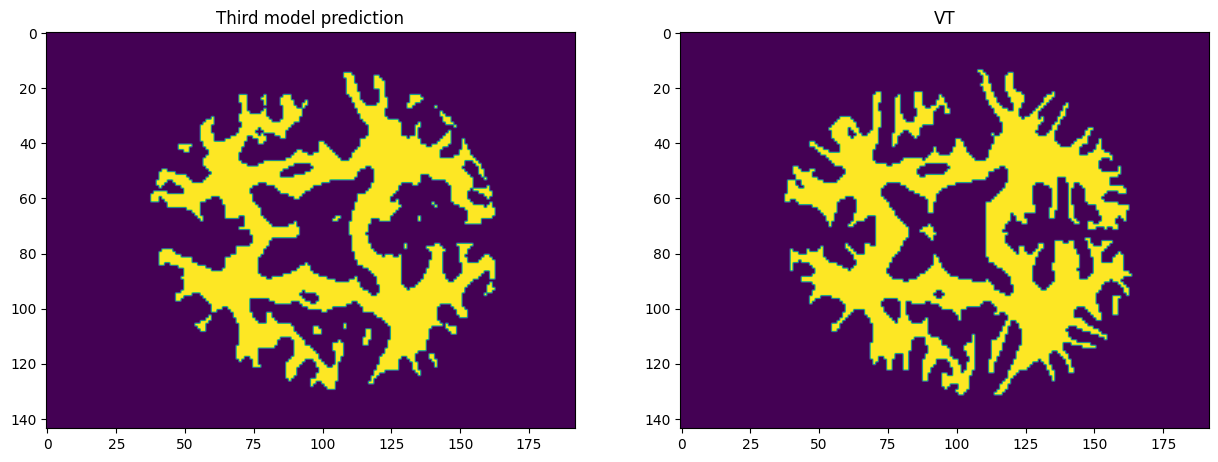

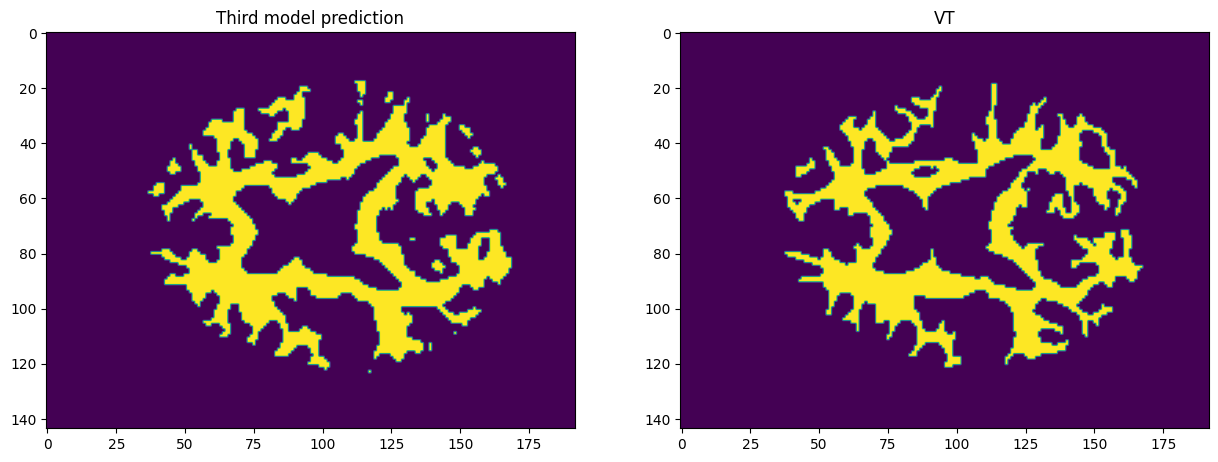

In [103]:
# Ces lignes nous permettent d'afficher la prédiction du troisième modèle (à gauche) et de ce qui est annoté dans VT (à droite)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,15])
ax1.imshow(pred_third_model[0][:,:,150])
ax1.set_title("Third model prediction")
ax2.imshow(test_VT[0][:,:,150] > 150)
ax2.set_title("VT")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,15])
ax1.imshow(pred_third_model[1][:,:,150])
ax1.set_title("Third model prediction")
ax2.imshow(test_VT[1][:,:,150] > 150)
ax2.set_title("VT")

In [104]:
# comme pour le model précédent nous devons calculer le dice que nous avons sur nos images
# Ici nous avons un dice de 0.84 sur notre image
print("The train dice factor is :  ", dice(pred_third_model[0], np.where(test_VT[0] > 150, 1, 0)))

The train dice factor is :   0.8362108355935506


## Résultats finaux

In [105]:
# En utilisant les 3 models précédents et en ajustants leurs poids nous arrivons à générer une prédiction globale  

predictions_stage1 = np.round(first_model.predict(XVALID)).reshape(512, 144, 192)
predictions_stage2 = np.round(second_model.predict(XVALID_second_model)).reshape(512, 144, 192)
predictions_stage3 = np.round(third_model.predict(XVALID_third_model)).reshape(512, 144, 192)

final_predictions = 10 * predictions_stage1 + 140 * predictions_stage2 + 100 * predictions_stage3

16/16 [==============================] - 4s 221ms/step


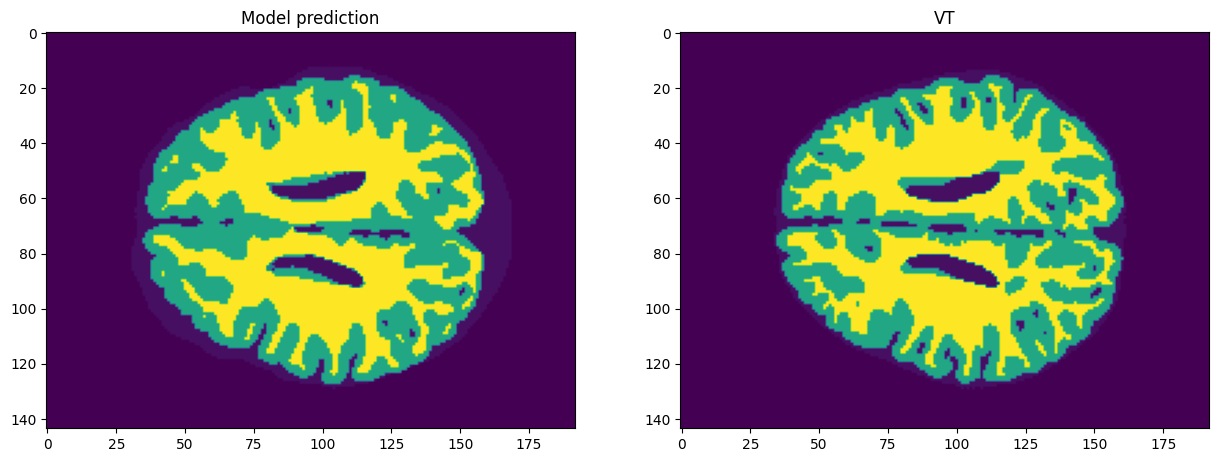

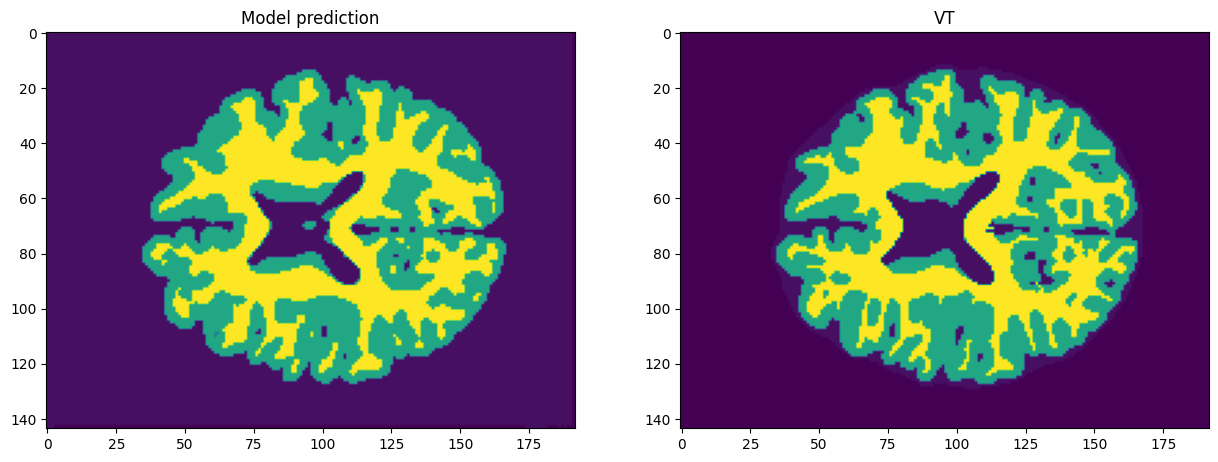

In [106]:
# Ces lignes nous permettent d'afficher la prédiction de la somme des 3 modèle (à gauche) et de ce qui est annoté dans VT (à droite)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,15])
ax1.set_title("Model prediction")
ax1.imshow(final_predictions[150,:,:])
ax2.set_title("VT")
ax2.imshow(val_VT[0][:,:,150])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[15,15])
ax1.set_title("Model prediction")
ax1.imshow(final_predictions[256 + 150,:,:])
ax2.set_title("VT")
ax2.imshow(val_VT[1][:,:,150])